In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
import string
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dotenv import load_dotenv
import os

import warnings
warnings.filterwarnings("ignore")

load_dotenv()
directory = os.getenv("path")

In [9]:
def ChangeExemplarsToBinary(datasetPath: str) -> pd.DataFrame:
    toBinary_df = pd.read_csv(datasetPath)
    # toBinary_df = toBinary_df.sort_values(by=["station_id"])
    # toBinary_df = toBinary_df.reset_index(drop=True)
    # toBinary_df.index += 1
    toBinary_df = toBinary_df.iloc[:, 1:]

    for col in toBinary_df.columns:
        unique_values = toBinary_df[col].unique().tolist()
        toBinary_df[col] = toBinary_df.index.map(
            lambda x: 1 if x in unique_values else 0
        )
        # for each column name add _ classification to the name
        # toBinary_df.rename(columns={col: col + "_" + datasetPath}, inplace=True)

    return toBinary_df

# test:
datasetPath = os.path.join(directory, "computed_data/ap_results", "func.csv")
ChangeExemplarsToBinary(datasetPath)

,2011_func_metrics,2012_func_metrics,2013_func_metrics,2014_func_metrics,2015_func_metrics,2016_func_metrics,2017_func_metrics,2018_func_metrics,2019_func_metrics,2020_func_metrics
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,1,1,1,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
128,0,0,0,0,0,0,0,0,0,1
129,1,0,0,0,0,0,0,0,0,0
130,0,0,0,0,0,1,0,1,0,0
131,0,0,0,0,0,0,0,0,0,0


In [10]:
def exemplarStabilityIndex(classification):
    df = ChangeExemplarsToBinary(classification)
    nameClass = classification.split("-")[1]
    df[f"sum_exemplars_{nameClass}"] = df.sum(axis=1)
    sum_list = df[f"sum_exemplars_{nameClass}"].to_list()
    return sum_list

In [131]:
func_df = exemplarStabilityIndex(os.path.join(directory, "computed_data/ap_results", "func.csv"))
func_climate_df = exemplarStabilityIndex(os.path.join(directory, "computed_data/ap_results", "func_climate.csv"))
func_climate_struct_df = exemplarStabilityIndex(os.path.join(directory, "computed_data/ap_results", "all_attributes.csv"))

df = pd.DataFrame({"F": func_df, "FC": func_climate_df, "FCS": func_climate_struct_df})
df["ALL"] = df.sum(axis=1)

,F,FC,FCS,ALL
0,1,1,0,2
1,0,2,7,9
2,5,2,0,7
3,1,2,1,4
4,0,1,5,6
...,...,...,...,...
128,1,4,2,7
129,1,3,0,4
130,2,1,9,12
131,0,2,0,2


In [132]:
# binary for all attributes:
all_sub_set_df = df["ALL"]
all_binary_cvq_df = all_sub_set_df.map(lambda x: 1 if x < 2 else
                                                    (2 if (x >= 2) & (x<4)  else
                                                     (3 if (x >= 4) & (x<6)  else
                                                    (4 if (x >= 6)  & (x<8)else
                                                     5)))).to_frame("ALL")

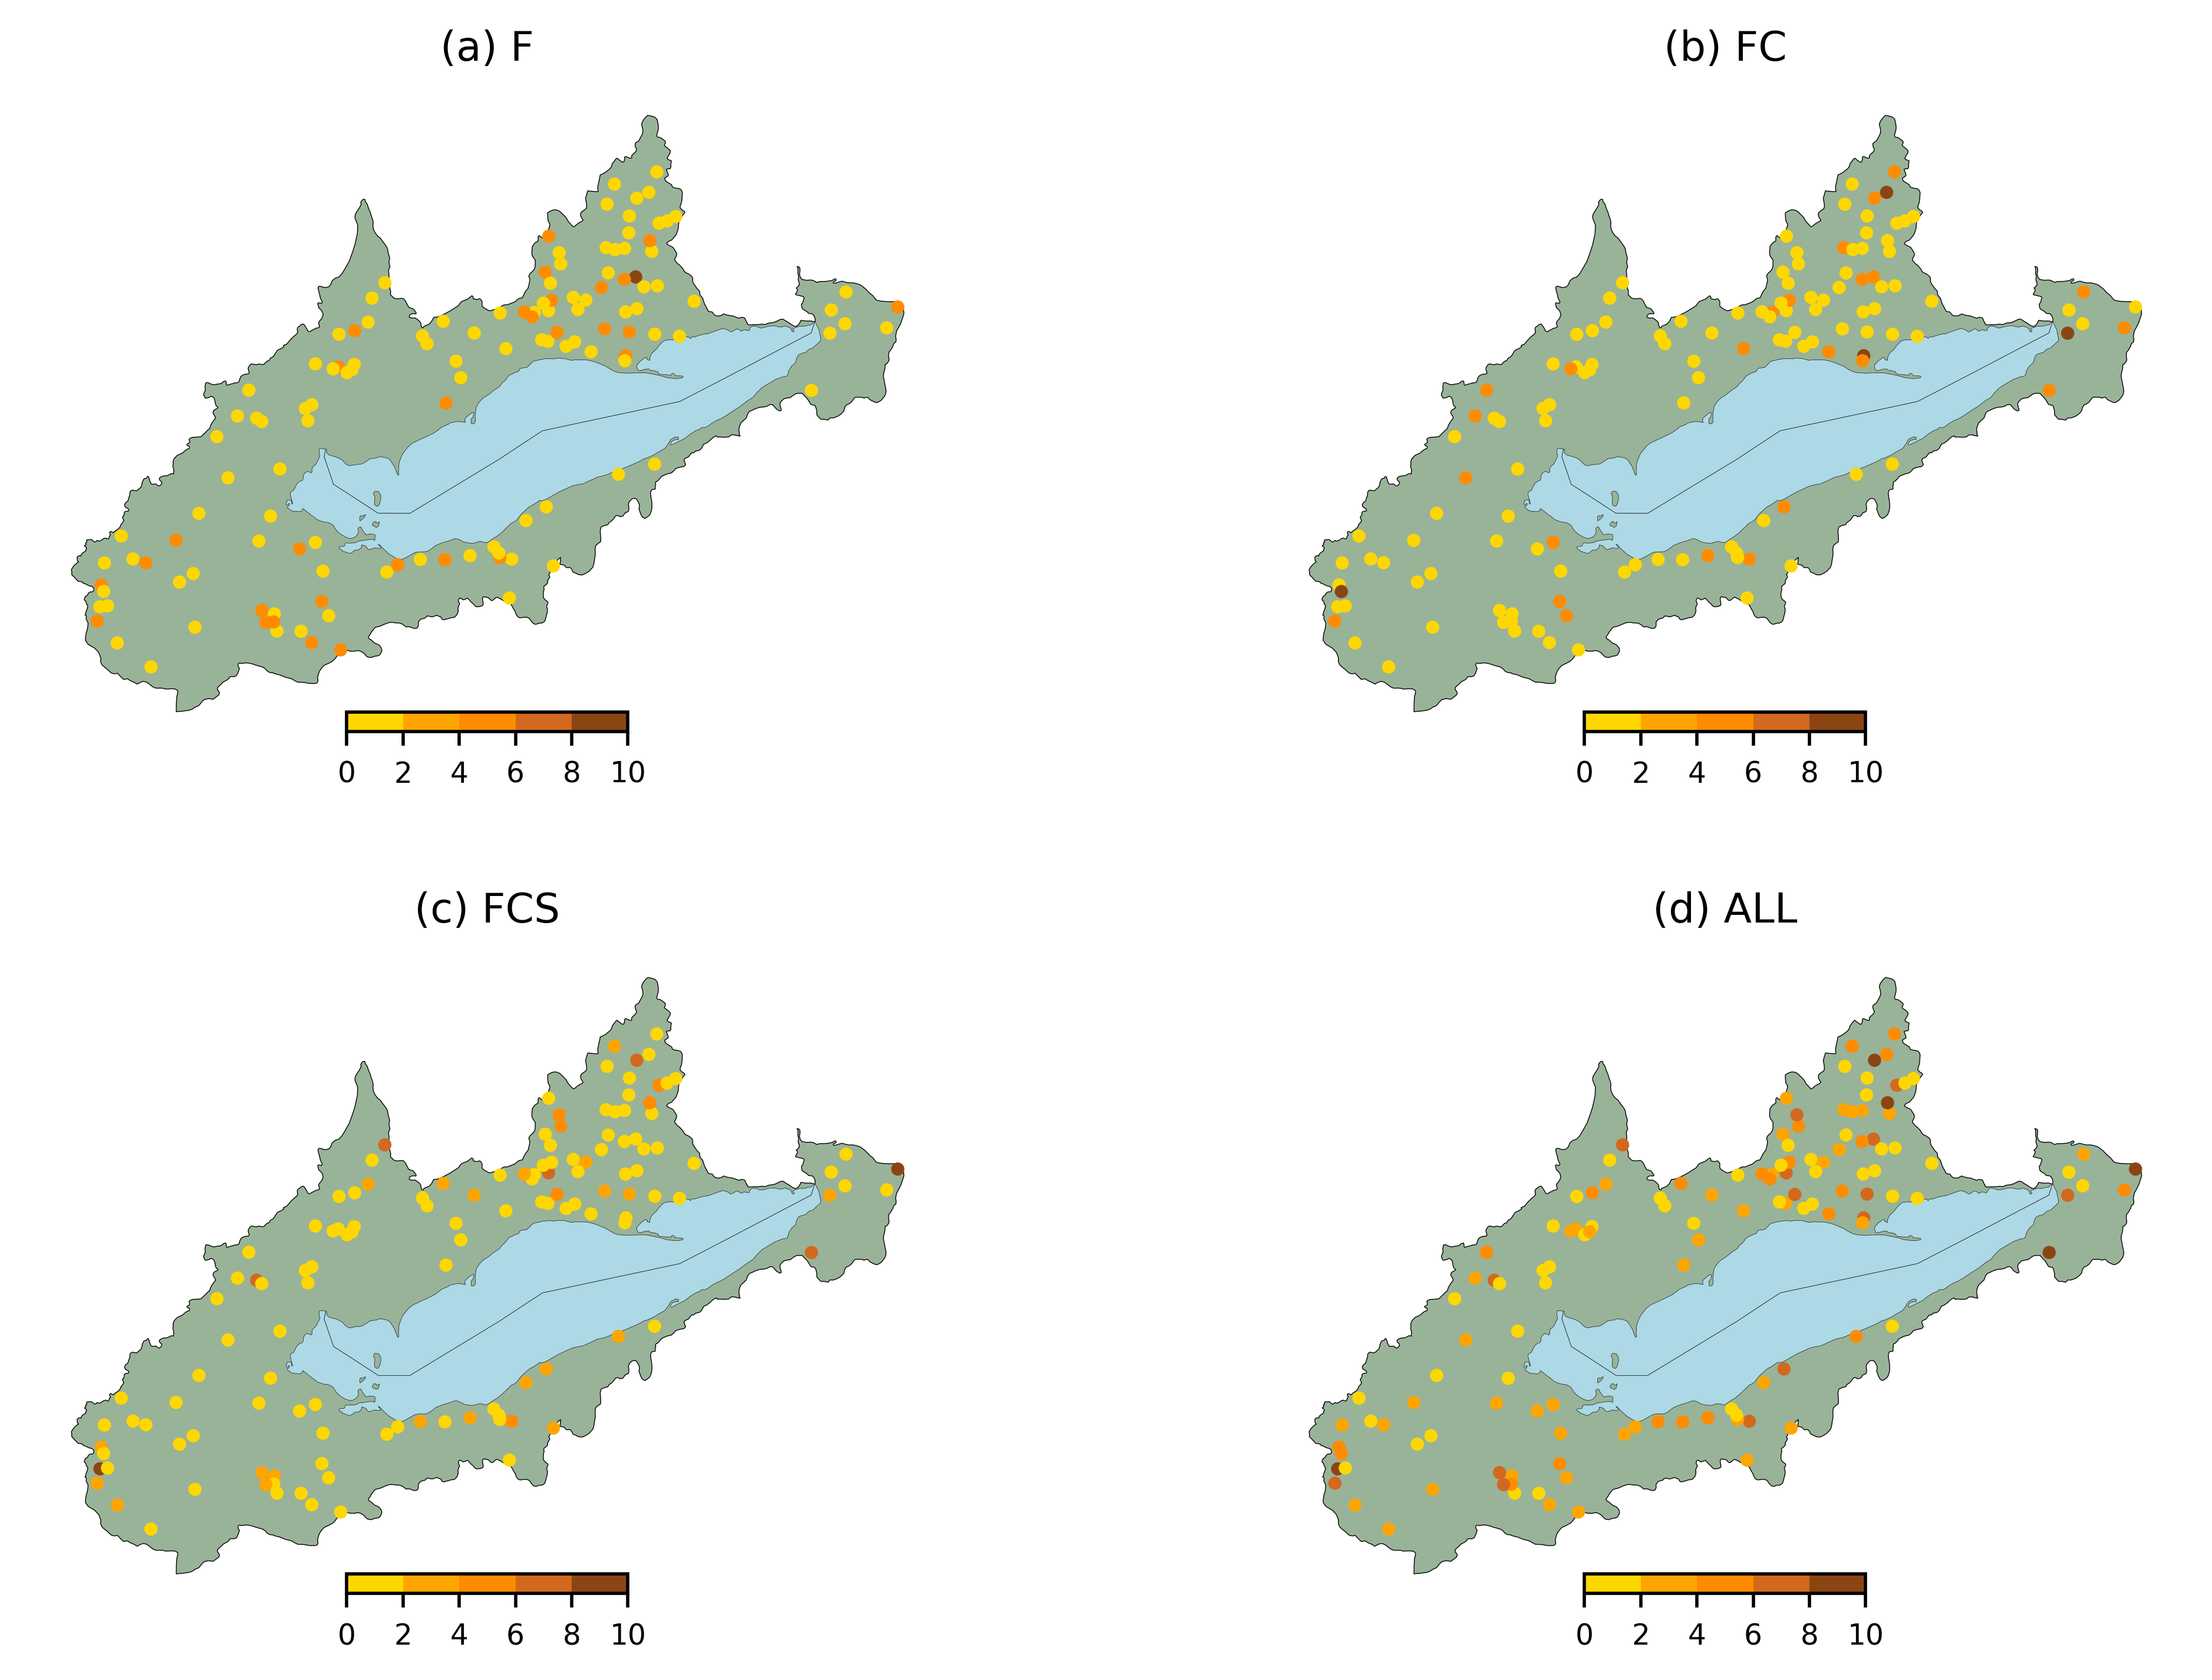

In [136]:
stations_df = pd.read_csv(os.path.join(directory, "raw_data", "stations_list.csv"), index_col=0)
LEB_polygon = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "LakeErieBasinBoundaries.shp"))
Lake = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "LakeErie.shp"))
st_clair = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "hydro_p_LakeStClair", "hydro_p_LakeStClair.shp"))

sub_set_df = df.iloc[:,:-1]
binary_cvq_df = sub_set_df.applymap(lambda x: 1 if x <2 else
                                                    (2 if (x >= 2) & (x<4)  else
                                                     (3 if (x >= 4) & (x<6)  else
                                                    (4 if (x >= 6)  & (x<8)else
                                                     5))))

binary_cvq_df['ALL'] = all_binary_cvq_df

gpd_propensity = gpd.GeoDataFrame(binary_cvq_df, geometry=gpd.points_from_xy(stations_df.longitude, stations_df.latitude))
gpd_propensity.set_crs(epsg=4326, inplace=True)

columnsP = gpd_propensity.columns.to_list()[:-1]

f, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6), linewidth=0, edgecolor='black', dpi=500)
axs = axs.flatten()

colors = ['gold', 'orange', 'darkorange', 'chocolate','saddlebrown']
cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=0, vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

labels_columns =  ["F", "FC", "FCS", "ALL" ]

for i, col in enumerate(columnsP):
    ax = axs[i]
    ax.set_aspect('auto')

    LEB_polygon.to_crs(epsg=4326).plot(ax=ax, color=(0.6, 0.7, 0.6),edgecolor="black", linewidth=0.2, markersize=1000)
    Lake.to_crs(epsg=4326).plot(ax=ax, color='lightblue',edgecolor="black", linewidth=0.09, markersize=1000)

    gpd_propensity.plot(column = col, ax=ax,
            legend = False, markersize = 5, cmap=cmap)
    
    
    ax.set_axis_off()

    title_str = f"({string.ascii_lowercase[i]}) {labels_columns[i]}"
    ax.set_title(title_str, size=10)
    ax.tick_params(labelsize=1)
#     cbar_ax = f.add_axes([0.5, .1, 0.12, 0.013])
#     ticks = np.linspace(0, 10,6)

  # Create a new axis for the colorbar
    divider = make_axes_locatable(ax)
#     cax = divider.append_axes("bottom", size="5%", pad=0.4)
    cax = divider.append_axes("bottom", size="3%", pad=-0.1, aspect = 0.7)
    cbar = f.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks(np.linspace(0, 10, 6))
    cbar.ax.tick_params(labelsize=7)


def format_tick(x, pos):
        return int(x)

# # Use FuncFormatter to apply the format_tick function to the tick labels
# # cbar = f.colorbar(sm, cax=cbar_ax,orientation="horizontal", ticks=ticks, shrink=0.1)
# # cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_tick))
# # # cbar.ax.xaxis.set_major_formatter(ticker.NullFormatter())
# # cbar.ax.tick_params(labelsize=10, length=3)

plt.subplots_adjust(hspace=-.4, wspace=0, left = 0, right =.7, top = 1.3, bottom = 0)


['F', 'FC', 'FCS', 'ALL']